# Détection d'anomalie : Auto Encodeur

Le but de ce NoteBook est de créer notre Auto Encodeur. Afin d'ensuite pouvoir l'utiliser pour détecter les anomalies dans le jeu de données **Engine Wire** 
(cf [README](README.md)). Pour ce faire nous allons utiliser **PyTorch**, et nous allons devoir créer un DataSet pour stocker et pouvoir utiliser nos images.

## Création du dataset

Le but de cette partie est d'initialiser le dataset, afin de convertir nos images au format **Tenseur**, pour *PyTorch*. Ainsi nous pourrons commencer le traitements des images et l'entrainement de notre AutoEncodeur.



Les **Tenseur** (Tensor : [TorchAPI](https://pytorch.org/docs/stable/torch.html)) sont une sorte de matrice avec plus de dimensions (CF : *[Tenseur](https://fr.wikipedia.org/wiki/Tenseur)* ). 


<u>Ils sont définis comme suit :</u>    
>Soit V un espace vectoriel de dimension n sur un corps commutatif $\mathbb{K}$. L'espace dual V* est l'espace vectoriel formé de toutes les formes linéaires définies sur V. L'espace V* est aussi de dimension n. Les éléments de V et V* sont appelés respectivement vecteurs et covecteurs.

>Un tenseur est une application multilinéaire
>$$ {\displaystyle T:\underbrace {V^{*}\times \ldots \times V^{*}} _{h}\times \underbrace {V\times \ldots \times V} _{k}\to K} $$



### CustomImageDataSet

Le but du code suivant est de créer le dataset des données d'entrainements, en les importants depuis le dossier téléchargé depuis la base de données _ViDataset_.
Dans le dossier pour l'entrainement toutes les images sont labélisées **good**.


In [1]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (str): Chemin vers le répertoire contenant les images.
            transform (callable, optional): Transformations optionnelles à appliquer aux images.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        label = img_path.split("/")[-1]
        

        return image,label

# Définir les transformations à appliquer aux images
transform = transforms.Compose([
    transforms.ToTensor()           # Convertir l'image en tenseur PyTorch
])

# Chemin vers le répertoire contenant les images
image_dir = 'engine_wiring/train/good'

# Créer une instance du dataset
dataset = CustomImageDataset(image_dir=image_dir, transform=transform)

# Créer un DataLoader pour itérer sur le dataset
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


    

    

Nous affichons une images, pour vérifier que notre DataSet est fonctionnel.

0000.png


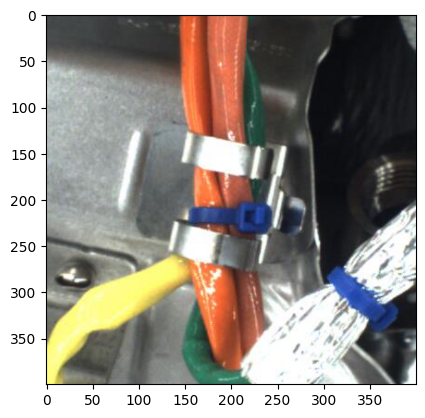

In [2]:
plt.imshow(dataset[1][0].permute(1,2,0)) # Affiche une images du dataset
print(dataset[0][1])

## AutoEncodeur

### Le Corps

Dans cette partie nous allons créer les premières classes nécessaire à notre AutoEncodeur, et initialiser les *fonctions* importantes. 

In [3]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

tensor_transform = transforms.ToTensor()

#Ici nous créons un dataLoader pour itérer sur nos images dans le DataSet
#Nous choisissons aussi une taille de Batch (ici 16)
loader = torch.utils.data.DataLoader(dataset=dataset,batch_size=16,shuffle=True)


#### Création de la classe principale

Dans le code suivant nous définissons 2 classes, pour notre AutoEncodeur.
Un AutoEncodeur sans couche de convolutions (*AutoEncodeur*) , et un avec (*AutoEncodeurConv*). Cependant après plusieurs tests, nous sommes arrivés à la conclusion qu'un réseau avec des couches de convolution et quelques couches linéaires etait plus efficace que sans couche de convolution.

Pour les couches de notre modèles, nous allons utiliser, plusieurs fonctions d'activation notamment : 
$ReLU:  (x \to max(0,x) )$, $Sigmoid: (x \to \frac{1}{1+e^{-x}})$

Aussi nous aurons des couches linéaires : $Linear: x \to xA^T+B $ avec A les poids, B les biais, et x la sortie de la couches précedente.

Et dans *AutoEncodeurConv* des couches de convolutions : 
La valeur d’un pixel de sortie Y(i,j) est donnée par :
$$Y(i,j)=\sum_{m=0}^{k_H−1}\sum_{n=0}^{k_W−1}X(i+m,j+n)⋅K(m,n)+b$$ 
 
où **X** : l'entrée (image ou feature map) de dimensions (H,W),
**K** : le noyau de convolution de dimensions ($k_H$,$k_W$),
**Y** : la sortie (feature map après convolution),
**b** : le biais ajouté après la convolution,
**s** : le stride (décalage du filtre),
**p** : le padding (ajout de pixels pour conserver la taille).


Aussi nous aurons besoin d'une méthode pour faire la propagation avant *forward*

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AutoEncodeur(torch.nn.Module):
    def __init__(self): # j'ai mis this pour faire comme en java, mais en vrai on utilise self
        super().__init__()

        #Création d el'encodeur
        self.encodeur = torch.nn.Sequential(
            #Linear(entré, sortie) -> matrice entré x sortie
            torch.nn.Linear(3*400 * 400,1000), # La taille de la couche
            torch.nn.ReLU(), # La fonction d'activation
            torch.nn.Linear(1000, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50)
        )


        self.decodeur = torch.nn.Sequential(
            torch.nn.Linear(50, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 3*400*400),
            torch.nn.Sigmoid() #Sigmoid à la fin pour avori une valeur entre 0 et 1
        )


    def forward(self, x): # Le feedForward -> propagation avant
        encoded = self.encodeur(x)
        decoded = self.decodeur(encoded)
        return decoded


class AutoEncodeurConv(torch.nn.Module):
    def __init__(self):
        super().__init__()

        #Création de l'encodeur
        self.encodeur = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # (3, 400, 400) -> (16, 200, 200)
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (16, 200, 200) -> (32, 100, 100)
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (32, 100, 100) -> (64, 50, 50)
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (64, 50, 50) -> (128, 25, 25)
            torch.nn.ReLU(),

        )
        # Ajout de quelques couches linéaire
        self.fc_encodeur = torch.nn.Linear(128 * 25 * 25, 512)  # Réduction de dimension avant le décodage
        self.fc_decodeur = torch.nn.Linear(512, 128 * 25 * 25) 

        # Décodeur
        self.decodeur = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (128, 25, 25) -> (64, 50, 50)
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64, 50, 50) -> (32, 100, 100)
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (32, 100, 100) -> (16, 200, 200)
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (16, 200, 200) -> (3, 400, 400)
            torch.nn.Sigmoid()
        )


    def forward(self, x): # Le feedForward -> propagation avant
        encoded = self.encodeur(x)

        encoded = encoded.view(encoded.size(0), -1)  # Aplatir le tensor pour la couche linéaire
        encoded = self.fc_encodeur(encoded)

        # Passer par la couche linéaire inverse dans le décodeur
        decoded = self.fc_decodeur(encoded)

        # Reshaping pour correspondre aux dimensions de l'image
        decoded = decoded.view(decoded.size(0), 128, 25, 25)

        decoded = self.decodeur(decoded)
        return decoded





In [5]:
model = AutoEncodeurConv().to("cuda")
fonction_perte = torch.nn.MSELoss()
#fonction_perte = torch.nn.BCELoss()

#lr : learning rate 
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4, weight_decay=1e-8)

Pour notre fonction de coût nous utiliserons : MSE ($\sum (x-e)^2$ ) car BCE ($ y log(\^y​)+(1−y) log(1−\^y) $) réduit la perte plus lentement.

L'optimiseur est le moyen de calculer la descente de gradient, [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)  est le plus "efficace" dans notre cas (converge le plus vite, et vers un bon minimum), il en existe d'autre la descente de gradient de base, descente de Newton, descente de gradient stochastique, Adam est une amélioration de la descente de gradient stochastique.

### Entrainement du modèle



Dans le code suivant, nous entrainons notre modèles, sur 61 générations, nous affichons toutes les 10 epochs une des sorties de notre modèle (à droite) et l'image d'entrée (à gauche).

Epoch : 0-> 0.10393574088811874


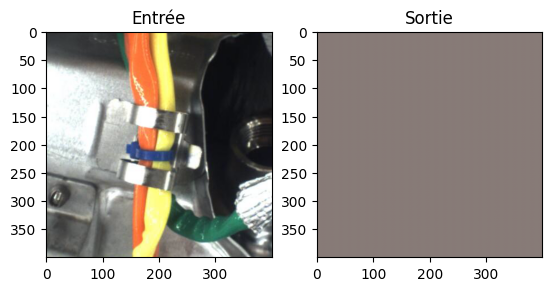

Epoch : 10-> 0.04612977057695389


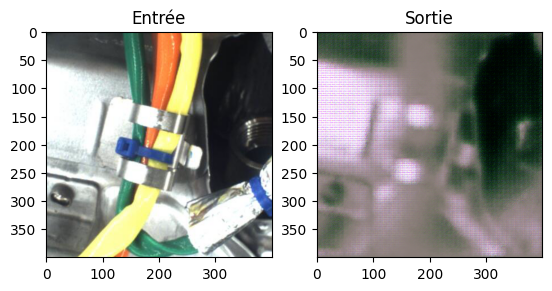

Epoch : 20-> 0.02441912516951561


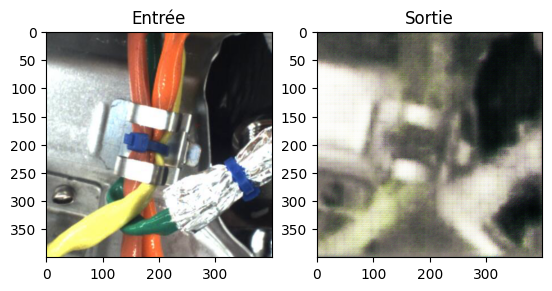

Epoch : 30-> 0.014011713676154613


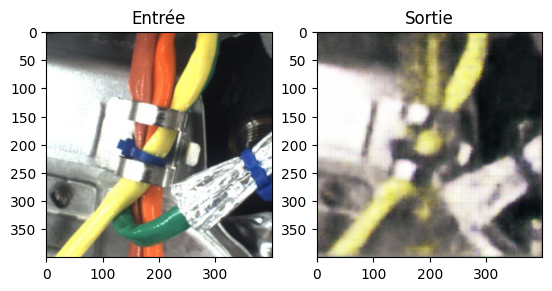

Epoch : 40-> 0.009643174707889557


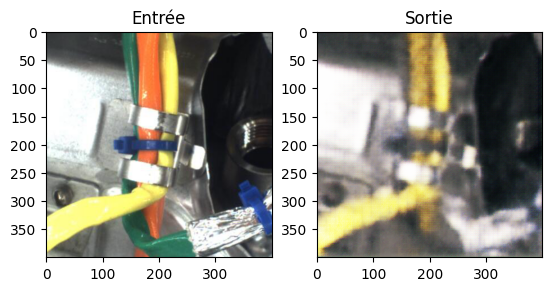

Epoch : 50-> 0.007391487248241901


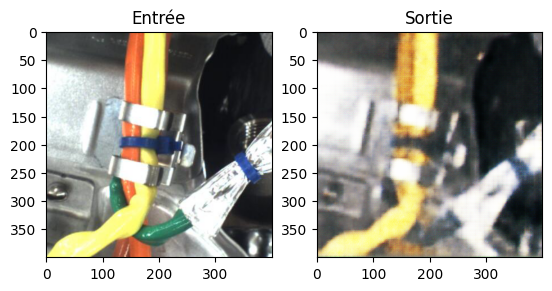

Epoch : 60-> 0.005967017263174057


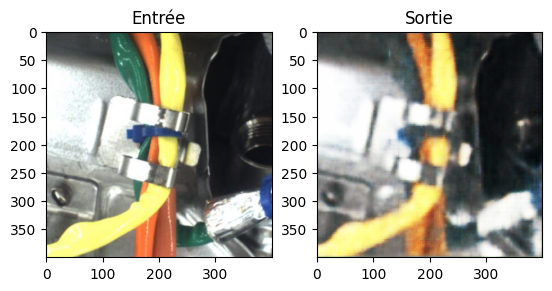

In [6]:
import numpy as np

epochs = 61
outputs = []
losses = []


for epoch in range(epochs):
    for (image, _) in loader: #Pour tester en batch, loader est l'itérateur du jeu de données
      image=image.to("cuda")

      optimizer.zero_grad()

      # Calcul de la propagation
      reconstructed = model(image) #On calcul l'image génerer par le réseau
       
      # Calcul de la perte
      loss = fonction_perte(reconstructed, image)
       

      # On fait la rétropropagation du gradient
      loss.backward()
      #On mets à jour les paramètres
      optimizer.step() 
       
      
    losses.append(loss.item())
    
    if epoch %10 == 0:
      print("Epoch : " + str(epoch) + "-> "+ str(losses[-1]))

      plt.subplot(1,2,1)
      image = image[-1].reshape(3,400,400).permute(1, 2, 0)
      plt.imshow(image.cpu().numpy())
      plt.title("Entrée")

      item= reconstructed[-1].reshape(3, 400, 400).permute(1, 2, 0)
      item = item.cpu().detach().numpy()
      plt.subplot(1,2,2)
      plt.title("Sortie")
      plt.imshow(item)

      plt.show()




Le graphique suivant affiche la valeur de fonction perte en fonctions des itérations.
On constate qu'elle diminue.

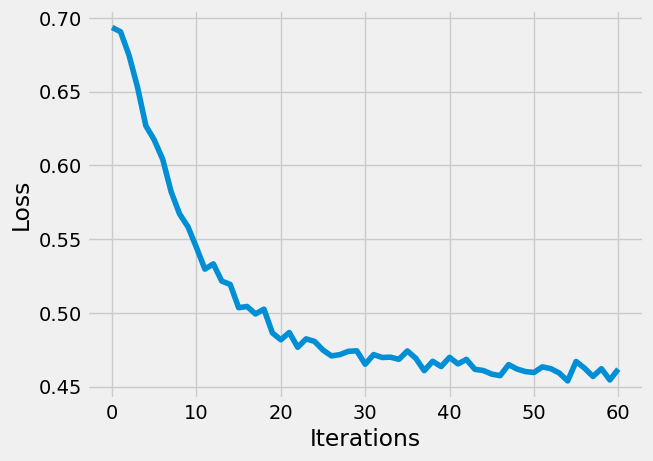

In [ ]:

# On affiche la fonction perte sur les derniérs calcul
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
losses2 = []
for i in losses:
    #losses2.append(i.detach().cpu().numpy())
    pass

# Plotting the last 100 values
plt.plot(losses[-100:])

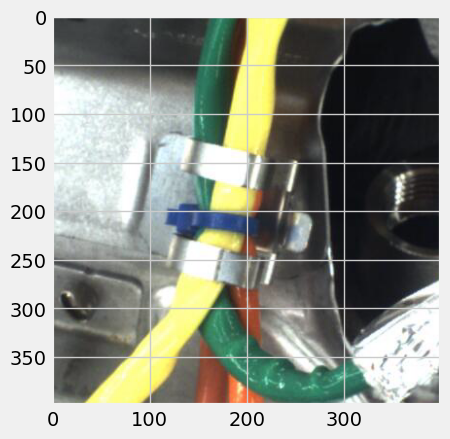

In [ ]:
%%script false --no-raise-error
#pour afficher les 2 premiere image, à gauche c'elle donnée initialement, à droite c'elle généré par le réseau.
for i, item in enumerate(image):
   
  # Reshape the array for plotting
  item = item.reshape(3,400,400).permute(1, 2, 0)
  plt.imshow(item.cpu().numpy())


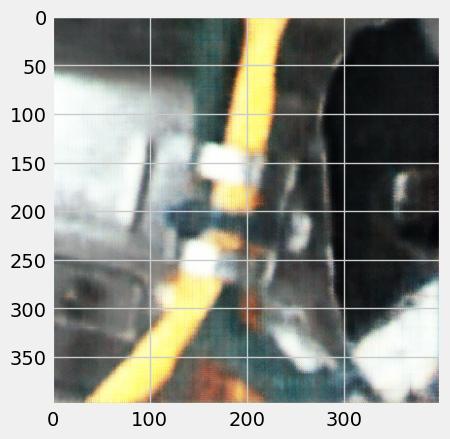

In [ ]:
%%script false --no-raise-error
for i, item in enumerate(reconstructed):
    item = item.reshape(3, 400, 400).permute(1, 2, 0)

    # Convertir en numpy pour Matplotlib
    item = item.cpu().detach().numpy()

    # Vérifier si les valeurs sont déjà dans la plage [0, 1]
    if item.max() <= 1:  # Si les valeurs sont déjà entre 0 et 1
        plt.imshow(item)
    else:
        # Si les valeurs sont dans la plage [0, 255], normalisez-les en [0, 1]
        plt.imshow(item)


### Stockage de notre Modèles

Dans le code suivant, nous créons le code pour stocker notre auto encodeur en local dans le fichier *model_weights.pth*

In [ ]:
# Save the autoencoder weights
import torch

def save(fileName = "model_weights.pth"): # Cette fonction sauvegarde le modèle.
    torch.save(model.state_dict(), fileName) # Sauvegarde le model

def load(fileName = "model_weights.pth"): # Cette fonction permet de charger le modèle à partir d'un fichier
    model.load_state_dict(torch.load(fileName)) # charge le model
    model.eval()  # Définir le modèle en mode évaluation (important pour certaines couches comme Dropout)


AutoEncodeurConv(
  (encodeur): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (fc_encodeur): Linear(in_features=80000, out_features=512, bias=True)
  (fc_decodeur): Linear(in_features=512, out_features=80000, bias=True)
  (decodeur): Sequential(
    (0): ReLU()
    (1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(16, 3, 

## Evaluation du modèle

Le but de cette section est de créer les fonctions necessaire à l'évaluation du modèle.
Pour ce faire nous allons devoir utiliser une erreur de reconstruction.
Plusieurs choix s'offre à nous  :
- Erreur L2 $\frac{1}{n} \sum^n_{i=1}(x_i - \^x_i)^2$

- Erreur L1 $\frac{1}{n} \sum^n_{i=1}|x_i-\^x_i|$

- Pixel à Pixel

- Cosinus Similarité $ \frac{X \cdot \hat{X}}{\|X\| \|\hat{X}\|} $

avec $x_i$ le pixel de l'image d'entrée et $\^x_i$ le pixel de l'image de sortie


### DataSet de Test

Dans le code suivant nous allons créerle dataSet pour les images de tests.

In [18]:

class CustomImageTestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (str): Chemin vers le répertoire contenant les images.
            transform (callable, optional): Transformations optionnelles à appliquer aux images.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [ os.path.join(root, fname) for root, dirs, files in os.walk(image_dir)  for fname in files if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        label = 'good' if img_path.split("/")[-2] == 'good' else 'anomalie'

        return image,label


transform = transforms.Compose([
    transforms.ToTensor()           
])

# Chemin vers le répertoire contenant les images de test
image_dir = 'engine_wiring/test'

# Créer une instance du dataset
datasetTest = CustomImageTestDataset(image_dir=image_dir, transform=transform)

# Créer un DataLoader pour itérer sur le dataset
test_loader = DataLoader(datasetTest, batch_size=1, shuffle=True)



### Evaluation

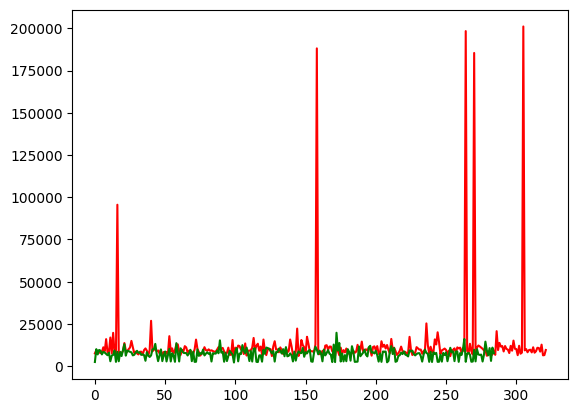

In [25]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Assumons que ton modèle est déjà entraîné et stocké dans 'model'
# Et que tu as une DataLoader pour les données de test
# Par exemple, test_loader est un DataLoader PyTorch pour les images de test

def evaluate_autoencoder(model, test_loader, device):
    model.eval()  # Passer le modèle en mode évaluation
    total_loss = 0
    num_samples = 0

    result = {'good':[],'anomalie':[]}

    with torch.no_grad():  # Désactiver le calcul des gradients
        for data in test_loader:
            inputs, label = data  # On se fiche de la cible dans un autoencodeur

            # Déplacer les données vers le bon périphérique (CPU ou GPU)
            inputs = inputs.to(device)

            # Passer les images à travers l'autoencodeur
            outputs = model(inputs) #image de sortie
            
            # Calcul de la perte L2 (Mean Squared Error)
            loss = F.mse_loss(outputs, inputs, reduction='sum')  # Utiliser 'sum' pour calculer la somme sur tout le batch
            result[label[0]].append(loss.item())
            total_loss += loss.item()
            num_samples += inputs.size(0)

    # Moyenne de la perte sur tout le dataset de test
    avg_loss = total_loss / num_samples

    return avg_loss,result


# Exemple d'évaluation

# Test loader est un DataLoader contenant les données de test
# Assume que test_loader est déjà défini (par exemple avec DataLoader de PyTorch)
#implementer testLoader
avg,re = evaluate_autoencoder(model, test_loader, device)


plt.plot(re['anomalie'],c='r')
plt.plot(re['good'],c='g')



## Métrique pour la fiabilité du modèle

Pour estimer la fiabilité du modèle nous allons devoir untiliser une métrique.
Ici aussi plusieurs choix s'offre à nous : 
